# Control cinemático de un robot PR
Iniciamos recordando las ecuaciones de la cinemática directa:
$$x=L_1+\theta_1+L_2cos(\theta_2)$$
$$y=L_2sin(\theta_2)$$

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def PR_fkine(theta1,theta2,L1,L2):
  x = L1+theta1+L2*np.cos(theta2)
  y = L2*np.sin(theta2)
  return np.array([[x],[y]])

PR_fkine(2,0,2,2)

array([[6.],
       [0.]])

Ahora construimos su matriz Jacobiana:

$$J=
\begin{bmatrix}
\frac{\partial x}{\partial \theta_1} &
\frac{\partial x}{\partial \theta_2} \\
\frac{\partial y}{\partial \theta_1} &
\frac{\partial y}{\partial \theta_2}
\end{bmatrix}
$$

$$J=
\begin{bmatrix}
1 &
-L_2sin(\theta_2) \\
0 &
L_2cos(\theta_2)
\end{bmatrix}
$$


O también la podemos obtener simbólicamente:

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

theta1, theta2, L1, L2 = sp.symbols('theta1 theta2 L1 L2')
x = L1 + theta1 + L2 * sp.cos(theta2)
y = L2*sp.sin(theta2)
f = sp.Matrix([[x],[y]])
f
J = f.jacobian([theta1, theta2])
J

Matrix([
[1, -L2*sin(theta2)],
[0,  L2*cos(theta2)]])

In [3]:
def J_PR(theta1,theta2,L1):
  J = np.array([[-np.sin(theta1)*(L1+theta2),np.cos(theta1)],[np.cos(theta1)*(L1+theta2),np.sin(theta1)]])
  return

Con esta matriz, podemos obtener la velocidad en espacio de la tarea de nuestro manipulador a partir de la velocidad en el espacio articular:
$$\begin{bmatrix}\dot{x}\\\dot{y}\end{bmatrix} = J(\theta_1,\theta_2)\begin{bmatrix}\dot{\theta_1}\\\dot{\theta_2}\end{bmatrix}= J(\theta_1,\theta_2)\begin{bmatrix}\omega_1\\\omega_2\end{bmatrix}$$

In [4]:
omega1, omega2 = sp.symbols('omega1 omega2')
xp = J*sp.Matrix([[omega1],[omega2]])
xp

Matrix([
[-L2*omega2*sin(theta2) + omega1],
[          L2*omega2*cos(theta2)]])

In [5]:
v1 = xp.subs({L1:2, L2:2, theta1:1, theta2:0, omega1:0 ,omega2:sp.pi/4})
v1

Matrix([
[   0],
[pi/2]])

In [6]:
xpn = sp.lambdify((theta1,theta2,omega1,omega2,L1),xp,modules="numpy")
xpn(np.pi/4,2,np.pi/8,4,3)
Jn = sp.lambdify((theta1,theta2,L1),J,modules="numpy")
Jn(np.pi/4,2,3)

array([[1, -0.909297426825682*L2],
       [0, -0.416146836547142*L2]], dtype=object)

# Control cinemático

$$\dot{x} = J\omega$$

Yo puedo fijar $\omega$ a lo que yo quiera, si $J$ es invertible entonces puedo fijarlo a:
$$\omega = J^{-1}(\dot{x_d}+K_p(x_d-x))$$




<>:66: SyntaxWarning: invalid escape sequence '\i'
<>:66: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2358301528.py:66: SyntaxWarning: invalid escape sequence '\i'
  J \in R^{2x2}


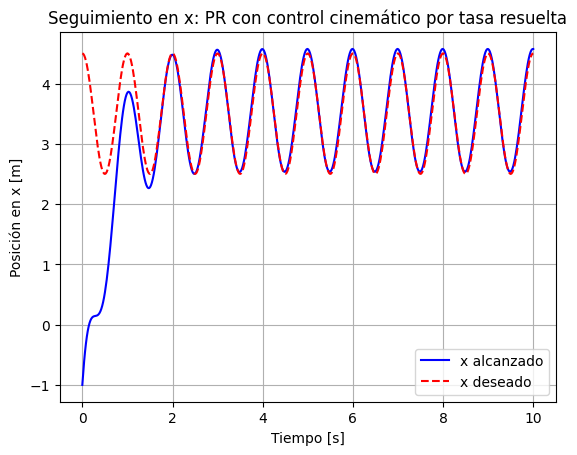

In [7]:
# -----------------------------
# Parámetros de simulación y trayectorias de referencia en el espacio de la tarea (x,y)
# -----------------------------

t = np.linspace(0, 10, 500)      # Vector de tiempo: 0 a 10 s con 1000 muestras
dt = t[1] - t[0]                 # Paso de integración temporal (s)

# Trayectoria deseada del efector final:
# Círculo de radio 1 centrado en (1.5, 0) que se recorre con velocidad angular 2π rad/s
xd = 3.5 + np.cos(2*np.pi*t)     # x_d(t)
yd = 0   + np.sin(2*np.pi*t)     # y_d(t)

# Apilamos x_d e y_d como vector 2xN para trabajar cómodamente
Xd = np.stack([xd, yd])

# Derivadas deseadas (velocidades cartesianas) obtenidas por diferenciación analítica
xdp = -2*np.pi*np.sin(2*np.pi*t) # \dot{x}_d(t)
ydp =  2*np.pi*np.cos(2*np.pi*t) # \dot{y}_d(t)

# Vector de velocidades deseadas en el espacio de la tarea (2xN)
Vd = np.stack([xdp, ydp])

# -----------------------------
# Parámetros geométricos y de control del robot PR (planar)
# -----------------------------

L1 = 2   # Longitud/offset asociado al primer eslabón (según tu definición en PR_fkine)
L2 = 2   # Longitud del segundo eslabón (el rotacional)
Kp = 2   # Ganancia proporcional en el espacio de la tarea (control cinemático)

# -----------------------------
# Estados (articulares y cartesianos) y condiciones iniciales
# -----------------------------

# theta tendrá dos filas: q1 (prismático) y q2 (rotacional). Tamaño 2xN
theta = np.zeros([2, len(t)])

# X almacenará la posición cartesiana alcanzada (x, y). Tamaño 2xN
X = np.zeros([2, len(t)])

# Condición inicial articular (q1, q2) = (0, 0)
theta[:, 0] = [-1, np.pi]

# Posición cartesiana inicial usando tu cinemática directa PR (debe devolver vector 2x1 o 2,)
X[:, 0] = PR_fkine(theta[0, 0], theta[1, 0], L1, L2).reshape(2,)

# -----------------------------
# Jacobiano del robot PR
# -----------------------------
def J_PR(theta1, theta2, L2):
    """
    Jacobiano de un manipulador planar PR con:
      - q1: articulación prismática (traslación en x base)
      - q2: articulación rotacional en el extremo del primer eslabón
      - L2: longitud del segundo eslabón

    Ecuaciones típicas (coherentes con una FKine del tipo):
        x = q1 + L2*cos(q2)
        y =      L2*sin(q2)

    Entonces:
        dx/dt = 1 * dq1 + (-L2*sin(q2)) * dq2
        dy/dt = 0 * dq1 + ( L2*cos(q2)) * dq2

    Retorna:
        J \in R^{2x2}
    """
    J = np.array([
        [1,             -L2*np.sin(theta2)],
        [0,              L2*np.cos(theta2)]
    ])
    return J

# -----------------------------
# Bucle de simulación: control cinemático por tasa resuelta
# -----------------------------
# Ley de control (discreta, Euler explícito):
#   qdot = J^{-1} [ v_d + Kp (x_d - x) ]
#   q(k+1) = q(k) + qdot * dt
#
# Donde:
#   - v_d es la velocidad deseada en el espacio de la tarea
#   - Kp (x_d - x) es un término proporcional en tarea (regulación/seguimiento)
#   - Se asume que J es invertible (evitar cos(q2) = 0 para este Jacobiano)
# -----------------------------

for i in range(1, len(t)):
    # Jacobiano en la configuración anterior
    J = J_PR(theta[0, i-1], theta[1, i-1], L2)

    # Inversa del Jacobiano (¡Atención a singularidades cuando cos(theta2)=0!)
    Jinv = np.linalg.inv(J)

    # Control de tasa resuelta en el espacio articular:
    # omega_d = dq/dt = J^{-1} (v_d + Kp (x_d - x))
    omega_d = Jinv @ (Vd[:, i] + Kp * (Xd[:, i] - X[:, i-1]))

    # Integración (Euler hacia adelante) para actualizar las coordenadas articulares
    theta[:, i] = theta[:, i-1] + omega_d * dt

    # Actualizamos la posición cartesiana alcanzada con la nueva configuración
    X[:, i] = PR_fkine(theta[0, i], theta[1, i], L1, L2).reshape(2,)

# -----------------------------
# Visualización: comparación de x(t) alcanzado vs x_d(t)
# -----------------------------
plt.plot(t, X[0, :], 'b',   label='x alcanzado')
plt.plot(t, Xd[0, :], 'r--', label='x deseado')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición en x [m]')
plt.title('Seguimiento en x: PR con control cinemático por tasa resuelta')
plt.legend()
plt.grid(True)

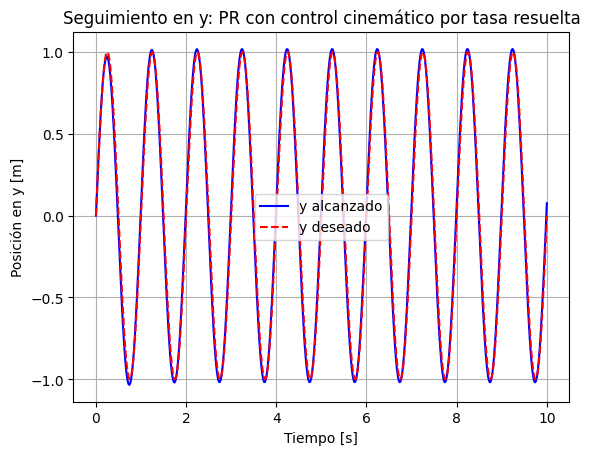

In [8]:
# -----------------------------
# Visualización: comparación de y(t) alcanzado vs y_d(t)
# -----------------------------
plt.plot(t, X[1, :], 'b',   label='y alcanzado')
plt.plot(t, Xd[1, :], 'r--', label='y deseado')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición en y [m]')
plt.title('Seguimiento en y: PR con control cinemático por tasa resuelta')
plt.legend()
plt.grid(True)

In [ ]:
# @title Animación PR con tramas RGB, trayectoria deseada y rastro
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_PR(theta, X, Xd, t, L1, L2, axis_len=0.4, trail=True, skip=2):
    """
    Anima un manipulador planar PR con:
      - Eslabones en negro
      - Tramas RGB en base, junta prismática y efector final
      - Trayectoria deseada completa
      - Rastro (trayectoria alcanzada) en línea punteada

    Parámetros clave:
      theta: 2xN (q1 prismático [m], q2 rotacional [rad])
      X:     2xN posiciones alcanzadas (x,y)
      Xd:    2xN posiciones deseadas (x_d, y_d)
      t:     vector de tiempo (N,)
      L1:    offset/longitud fija del primer tramo (m)
      L2:    longitud del segundo eslabón (m)
      axis_len: longitud visual de los ejes locales de cada trama
      trail: si True, dibuja el rastro del EE
      skip:  muestra 1 de cada 'skip' pasos para aligerar la animación
    """
    # ----- Ventana y límites -----
    fig, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box')
    margin = 0.6

    # Estima límites a partir de la deseada y la alcanzada (y unos puntos de seguridad)
    x_all = np.concatenate([
        Xd[0], X[0], np.array([0.0, L1 + np.max(theta[0]) + L2, L1 + np.min(theta[0]) - L2])
    ])
    y_all = np.concatenate([
        Xd[1], X[1], np.array([0.0, +L2, -L2])
    ])
    ax.set_xlim(np.min(x_all) - margin, np.max(x_all) + margin)
    ax.set_ylim(np.min(y_all) - margin, np.max(y_all) + margin)
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title('PR planar — eslabones (negro), tramas RGB, trayectoria y rastro')

    # ----- Curvas de referencia y rastro -----
    desired_line, = ax.plot(Xd[0], Xd[1], '--', linewidth=1.5, label='Trayectoria deseada')
    trail_line,   = ax.plot([], [], ':',  linewidth=1.8, label='Rastro (alcanzado)')

    # ----- Eslabones -----
    link1_line, = ax.plot([], [], 'k-', linewidth=3)
    link2_line, = ax.plot([], [], 'k-', linewidth=3)

    # Marcador del efector final
    ee_point,   = ax.plot([], [], 'o', markersize=5)

    # ----- Tramas RGB: líneas para ejes x (rojo) e y (verde) -----
    # Base (0), junta prismática (1), efector final (2)
    f0_x, = ax.plot([], [], '-', linewidth=2, color='r')  # x base
    f0_y, = ax.plot([], [], '-', linewidth=2, color='g')  # y base
    f1_x, = ax.plot([], [], '-', linewidth=2, color='r')  # x junta 1
    f1_y, = ax.plot([], [], '-', linewidth=2, color='g')  # y junta 1
    f2_x, = ax.plot([], [], '-', linewidth=2, color='r')  # x EE
    f2_y, = ax.plot([], [], '-', linewidth=2, color='g')  # y EE

    # Indicador de eje z (punto azul en el origen de cada trama)
    base_dot,  = ax.plot([], [], 'o', markersize=4, color='b')
    joint_dot, = ax.plot([], [], 'o', markersize=4, color='b')
    ee_dot,    = ax.plot([], [], 'o', markersize=4, color='b')

    # Texto de tiempo
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    # Utilidad para construir ejes locales a partir de origen y ángulo
    def frame_axes(origin, angle):
        c, s = np.cos(angle), np.sin(angle)
        x_axis = np.array([c, s])
        y_axis = np.array([-s, c])
        p = np.array(origin)
        return p, p + axis_len*x_axis, p + axis_len*y_axis

    def init():
        trail_line.set_data([], [])
        link1_line.set_data([], [])
        link2_line.set_data([], [])
        ee_point.set_data([], [])

        for ln in (f0_x, f0_y, f1_x, f1_y, f2_x, f2_y):
            ln.set_data([], [])

        base_dot.set_data([], [])
        joint_dot.set_data([], [])
        ee_dot.set_data([], [])
        time_text.set_text('')

        ax.legend(loc='upper right')
        return (link1_line, link2_line, ee_point, trail_line,
                f0_x, f0_y, f1_x, f1_y, f2_x, f2_y,
                base_dot, joint_dot, ee_dot, time_text)

    def update(k):
        idx = min(k * skip, t.size - 1)

        q1 = theta[0, idx]
        q2 = theta[1, idx]

        # Orígenes de cada trama (coherente con el Jacobiano usado):
        # O0: base
        O0 = np.array([0.0, 0.0])
        # O1: al final del tramo prismático, mantiene orientación 0
        O1 = np.array([L1 + q1, 0.0])
        # O2: efector final; orientación q2 respecto a la base
        O2 = np.array([L1 + q1 + L2*np.cos(q2), L2*np.sin(q2)])

        # Eslabones
        link1_line.set_data([O0[0], O1[0]], [O0[1], O1[1]])
        link2_line.set_data([O1[0], O2[0]], [O1[1], O2[1]])

        # Rastro
        if trail:
            trail_line.set_data(X[0, :idx+1], X[1, :idx+1])

        # Punto EE
        ee_point.set_data([O2[0]], [O2[1]])

        # Tramas RGB
        # Base (ángulo 0)
        p0, p0x, p0y = frame_axes(O0, 0.0)
        f0_x.set_data([p0[0], p0x[0]], [p0[1], p0x[1]])
        f0_y.set_data([p0[0], p0y[0]], [p0[1], p0y[1]])
        base_dot.set_data([O0[0]], [O0[1]])

        # Junta prismática (ángulo 0)
        p1, p1x, p1y = frame_axes(O1, 0.0)
        f1_x.set_data([p1[0], p1x[0]], [p1[1], p1x[1]])
        f1_y.set_data([p1[0], p1y[0]], [p1[1], p1y[1]])
        joint_dot.set_data([O1[0]], [O1[1]])

        # Efector final (ángulo q2)
        p2, p2x, p2y = frame_axes(O2, q2)
        f2_x.set_data([p2[0], p2x[0]], [p2[1], p2x[1]])
        f2_y.set_data([p2[0], p2y[0]], [p2[1], p2y[1]])
        ee_dot.set_data([O2[0]], [O2[1]])

        time_text.set_text(f't = {t[idx]:.2f} s')

        return (link1_line, link2_line, ee_point, trail_line,
                f0_x, f0_y, f1_x, f1_y, f2_x, f2_y,
                base_dot, joint_dot, ee_dot, time_text)

    interval_ms = max(10, int((t[1] - t[0]) * 1000))
    frames = int(np.ceil(t.size / skip))
    anim = FuncAnimation(fig, update, frames=frames, init_func=init,
                         blit=True, interval=interval_ms)
    plt.close(fig)
    return anim

# Ejecuta la animación (usa to_jshtml para Colab/Jupyter)
anim = animate_PR(theta, X, Xd, t, L1, L2, axis_len=0.5, trail=True, skip=2)
HTML(anim.to_jshtml())
